# 04 LightGBM: StratifiedKFold平均推論 vs Simple推論

`00_prepare_data.ipynb` で作成した Titanic の Train/Test を使い、
- `01` と同様の Simple 推論（1モデル）
- StratifiedKFold で学習した複数モデルの平均確率による推論
を比較します。

In [1]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt

SEED = 42
N_SPLITS = 5
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [2]:
# 00_prepare_data.ipynb で保存したデータを読み込む
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].astype(int)
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)

print(f'Train full shape: {X_train_full.shape}')
print(f'Test shape      : {X_test.shape}')
print('Train class ratio:', y_train_full.value_counts(normalize=True).sort_index().to_dict())
print('Test  class ratio:', y_test.value_counts(normalize=True).sort_index().to_dict())

Train full shape: (19536, 14)
Test shape      : (29306, 14)
Train class ratio: {0: 0.7606981981981982, 1: 0.2393018018018018}
Test  class ratio: {0: 0.6324643417730158, 1: 0.36753565822698425}


In [3]:
def build_model(seed):
    return lgb.LGBMClassifier(
        objective='multiclass',
        num_class=num_class,
        n_estimators=120,
        learning_rate=0.05,
        num_leaves=7,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=seed,
        bagging_seed=seed,
        feature_fraction_seed=seed,
        data_random_seed=seed,
        deterministic=True,
        force_col_wise=True
    )

def evaluate_split(split_name, y_true, pred, proba):
    return {
        'Split': split_name,
        'Accuracy': accuracy_score(y_true, pred),
        'F1_macro': f1_score(y_true, pred, average='macro'),
        'LogLoss': log_loss(y_true, proba, labels=class_labels)
    }

In [4]:
# 01と同様のSimple推論（Train/Validを1回だけ分割して1モデル学習）
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=SEED, stratify=None
)

simple_model = build_model(SEED)
simple_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='multi_logloss'
)

simple_proba_train = simple_model.predict_proba(X_train)
simple_pred_train = simple_model.predict(X_train)
simple_proba_valid = simple_model.predict_proba(X_valid)
simple_pred_valid = simple_model.predict(X_valid)
simple_proba_test = simple_model.predict_proba(X_test)
simple_pred_test = simple_model.predict(X_test)

simple_train_metrics = evaluate_split('Train', y_train, simple_pred_train, simple_proba_train)
simple_valid_metrics = evaluate_split('Valid', y_valid, simple_pred_valid, simple_proba_valid)
simple_test_metrics = evaluate_split('Test', y_test, simple_pred_test, simple_proba_test)

print('Simple inference completed.')

[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 14652, number of used features: 14
[LightGBM] [Info] Start training from score -0.273048
[LightGBM] [Info] Start training from score -1.431528
Simple inference completed.


In [5]:
# StratifiedKFold推論（各foldモデルのTest予測確率を平均）
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_proba = np.zeros((len(X_train_full), num_class))
test_proba_folds = []
fold_metric_rows = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train_full, y_train_full), start=1):
    X_tr = X_train_full.iloc[tr_idx]
    y_tr = y_train_full.iloc[tr_idx]
    X_va = X_train_full.iloc[va_idx]
    y_va = y_train_full.iloc[va_idx]

    model = build_model(SEED + fold)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='multi_logloss'
    )

    tr_proba = model.predict_proba(X_tr)
    tr_pred = model.predict(X_tr)
    va_proba = model.predict_proba(X_va)
    va_pred = model.predict(X_va)
    oof_proba[va_idx] = va_proba

    test_proba = model.predict_proba(X_test)
    test_pred = np.argmax(test_proba, axis=1)
    test_proba_folds.append(test_proba)

    train_metrics = evaluate_split('Train', y_tr, tr_pred, tr_proba)
    valid_metrics = evaluate_split('Valid', y_va, va_pred, va_proba)
    test_metrics = evaluate_split('Test', y_test, test_pred, test_proba)

    for metrics in [train_metrics, valid_metrics, test_metrics]:
        fold_metric_rows.append({
            'Fold': fold,
            'Split': metrics['Split'],
            'Accuracy': metrics['Accuracy'],
            'F1_macro': metrics['F1_macro'],
            'LogLoss': metrics['LogLoss']
        })

fold_result_df = pd.DataFrame(fold_metric_rows)
display(fold_result_df)

kfold_mean_metrics_df = fold_result_df.groupby('Split', as_index=False)[['Accuracy', 'F1_macro', 'LogLoss']].mean()
kfold_mean_metrics_df['Method'] = f'StratifiedKFold({N_SPLITS})'
kfold_mean_metrics_df = kfold_mean_metrics_df[['Method', 'Split', 'Accuracy', 'F1_macro', 'LogLoss']]
display(kfold_mean_metrics_df)

[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] Start training from score -0.273535
[LightGBM] [Info] Start training from score -1.429979
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of dat

,Fold,Split,Accuracy,F1_macro,LogLoss
0,1,Train,0.863322,0.792410,0.298953
1,1,Valid,0.863101,0.791036,0.293996
2,1,Test,0.723708,0.711826,0.701165
3,2,Train,0.865378,0.797312,0.296442
4,2,Valid,0.860251,0.787407,0.300169
5,2,Test,0.723094,0.711185,0.720887
6,3,Train,0.864035,0.794299,0.295063
7,3,Valid,0.863834,0.791715,0.306302
8,3,Test,0.722787,0.710034,0.709875
9,4,Train,0.864739,0.795109,0.296280


,Method,Split,Accuracy,F1_macro,LogLoss
0,StratifiedKFold(5),Test,0.722016,0.709259,0.711687
1,StratifiedKFold(5),Train,0.864263,0.794303,0.296660
2,StratifiedKFold(5),Valid,0.861742,0.790250,0.302005


In [6]:
kfold_proba_test = np.mean(np.stack(test_proba_folds, axis=0), axis=0)
kfold_pred_test = np.argmax(kfold_proba_test, axis=1)

simple_metrics_df = pd.DataFrame([
    { 'Method': 'Simple(01-like)', **simple_train_metrics },
    { 'Method': 'Simple(01-like)', **simple_valid_metrics },
    { 'Method': 'Simple(01-like)', **simple_test_metrics },
])

comparison_df = pd.concat([simple_metrics_df, kfold_mean_metrics_df], ignore_index=True)
comparison_df['Split'] = pd.Categorical(comparison_df['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
comparison_df = comparison_df.sort_values(['Split', 'Method']).reset_index(drop=True)

display(comparison_df)

pivot_acc = comparison_df.pivot(index='Split', columns='Method', values='Accuracy')
pivot_f1 = comparison_df.pivot(index='Split', columns='Method', values='F1_macro')
pivot_logloss = comparison_df.pivot(index='Split', columns='Method', values='LogLoss')

diff = pd.DataFrame({
    'Accuracy diff (StratifiedKFold - Simple)': pivot_acc[f'StratifiedKFold({N_SPLITS})'] - pivot_acc['Simple(01-like)'],
    'F1 diff (StratifiedKFold - Simple)': pivot_f1[f'StratifiedKFold({N_SPLITS})'] - pivot_f1['Simple(01-like)'],
    'LogLoss diff (StratifiedKFold - Simple)': pivot_logloss[f'StratifiedKFold({N_SPLITS})'] - pivot_logloss['Simple(01-like)']
}).reset_index()
print('Difference by split (StratifiedKFold - Simple)')
display(diff)

,Method,Split,Accuracy,F1_macro,LogLoss
0,Simple(01-like),Train,0.865070,0.796015,0.296756
1,StratifiedKFold(5),Train,0.864263,0.794303,0.296660
2,Simple(01-like),Valid,0.861794,0.790356,0.300717
3,StratifiedKFold(5),Valid,0.861742,0.790250,0.302005
4,Simple(01-like),Test,0.722173,0.709041,0.698131
5,StratifiedKFold(5),Test,0.722016,0.709259,0.711687


Difference by split (StratifiedKFold - Simple)


,Split,Accuracy diff (StratifiedKFold - Simple),F1 diff (StratifiedKFold - Simple),LogLoss diff (StratifiedKFold - Simple)
0,Train,-0.000806,-0.001711,-0.000097
1,Valid,-0.000051,-0.000106,0.001288
2,Test,-0.000157,0.000218,0.013556


Test prediction agreement: 0.9910


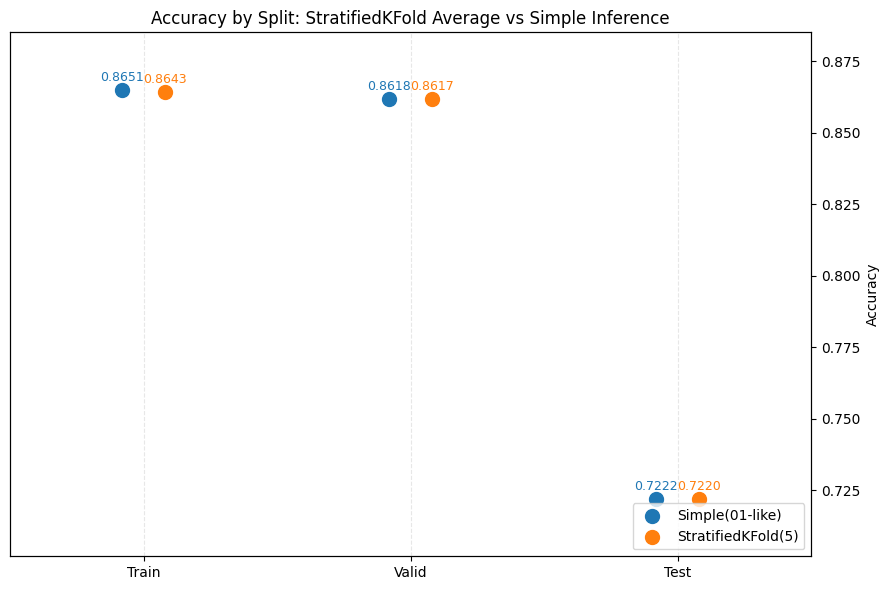

In [7]:
# Test予測ラベルの一致率を確認
agreement = (simple_pred_test == kfold_pred_test).mean()
print(f'Test prediction agreement: {agreement:.4f}')

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_simple = [pivot_acc.loc[s, 'Simple(01-like)'] for s in split_order]
acc_kfold = [pivot_acc.loc[s, f'StratifiedKFold({N_SPLITS})'] for s in split_order]

fig, ax = plt.subplots(figsize=(9, 6))
ax_right = ax.twinx()

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_simple, s=100, label='Simple(01-like)', color='tab:blue')
ax_right.scatter(x + offset, acc_kfold, s=100, label=f'StratifiedKFold({N_SPLITS})', color='tab:orange')

for i, score in enumerate(acc_simple):
    ax_right.text(x[i] - offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, score in enumerate(acc_kfold):
    ax_right.text(x[i] + offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

ax_right.set_ylabel('Accuracy')
all_acc = np.array(acc_simple + acc_kfold)
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.legend(loc='lower right')

plt.title('Accuracy by Split: StratifiedKFold Average vs Simple Inference')
plt.tight_layout()
plt.show()